In [74]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Handling Networks

<img src="imgs/sheldon.gif">

### Let's continue our exploration of the show Big Bang Theory with a focus on it's graph structure!

First, load the data that we prepared for you the data in a nice format:

In [4]:
lines = pd.read_pickle("data/BBT_lines.pkl")
lines.head()

,Season,Episode,Scene,Character,Line
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.


And let's define the characters that we are interested to study:

In [5]:
recurrent_characters = ['Amy', 'Arthur', 'Bernadette', 'Bert', 'Beverley', 'Emily', 'Howard', 
                       'Leonard', 'Leslie', 'Penny', 'Priya', 'Raj', 'Sheldon', 'Stuart', 'Wil', 
                       'Zack', 'Lucy', 'Kripke', 'Isabella']

## The Gossip Graph

Let us define _gossip_ as follows: if a dialogue line of character A mentions B by name in a scene that does not involve character B, we say that “A gossips about B” in that line. Multiple mentions of the same person in a single line are counted once, but a character can gossip about several others in the same line. For the sake of simplicity, we only consider gossips where the name of the recurrent character is mentioned as it appears in our list of characters; for example, if someone says "Cooper" and they mean Sheldon, we discard that.

Create the two following graphs first:

1. Create the _familiarity graph_, an undirected weighted graph, in which there is a node for each recurrent character, and an edge between two characters if they appear together in at least one scene. The weight of the edge between them is the number of scenes they appear in together. If an edge exists between two people in the familiarity graph, we say that they "know each other".
2. Create the _gossip graph_, which is a directed weighted graph, in which there there is a node for each recurrent character, and a directed edge from the node for A to the node for B if A has gossiped about B at least once. The weight of the edge is the number of scenes in which A has gossiped about B.

Visualise both graphs.

---

We compute the recurrent characters mentionned in each line:

In [42]:
def mentions(char, line):
    return [char_ for char_ in recurrent_characters if char != char_ and char_ in line]

mention = list(map(lambda e: mentions(*e), zip(lines.Character, lines.Line)))

In [43]:
lines['mentions'] = mention
lines.head()

,Season,Episode,Scene,Character,Line,mentions
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...,[]
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?",[]
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide...",[]
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?,[]
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.,[]


In [45]:
lines.mentions.apply(len).describe()

count    51292.000000
mean         0.153338
std          0.411589
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: mentions, dtype: float64

We remove mentionned characters if they are involved in the same scene:


In [64]:
# Group by scenes: list of characters by Scene (in same episode)
char_by_scene = lines.groupby(['Episode', 'Scene']).Character.unique()
char_by_scene = char_by_scene.apply(lambda ls: list(filter(lambda rec_char: rec_char in ls, recurrent_characters)))
char_by_scene.reset_index().head()

,Episode,Scene,Character
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,"[Leonard, Sheldon]"
1,Series 01 Episode 01 – Pilot Episode,All five in Leonard’s car.,"[Howard, Leonard, Penny, Sheldon]"
2,Series 01 Episode 01 – Pilot Episode,Back at the apartment.,"[Howard, Penny]"
3,Series 01 Episode 01 – Pilot Episode,In the bathroom.,"[Leonard, Penny]"
4,Series 01 Episode 01 – Pilot Episode,Inside Sheldon and Leonard’s apartment.,"[Howard, Leonard, Penny, Raj, Sheldon]"


In [65]:
def gossips(episode, scene, char_list):
    return [char for char in char_list if char not in char_by_scene[(episode, scene)]]

gossips = list(map(lambda e: gossips(*e), zip(lines.Episode, lines.Scene, lines.mentions)))

In [66]:
lines['gossips'] = gossips
lines.gossips.apply(lambda ls: len(ls) > 0).sum(), lines.shape[0]

(1715, 51292)

In [114]:
lines.head()

,Season,Episode,Scene,Character,Line,mentions,gossips
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...,[],[]
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?",[],[]
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide...",[],[]
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?,[],[]
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.,[],[]


In [124]:
fam = nx.Graph()
fam.add_nodes_from(recurrent_characters)

In [125]:
for charlst in char_by_scene:
    N = len(charlst)
    for i in range(N):
        for j in range(i+1, N):
            cur_w = fam.edges().get((charlst[i], charlst[j]))
            fam.add_edge(charlst[i], charlst[j], weight=1 if cur_w is None else cur_w['weight']+1)

In [126]:
# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

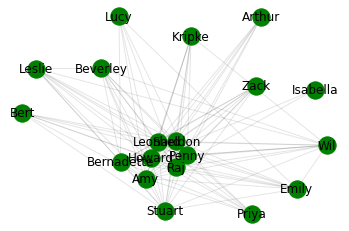

In [127]:
visualize_graph(fam, k=5, alpha=.1)

In [128]:
gos = nx.DiGraph()
gos.add_nodes_from(recurrent_characters)

In [130]:
for gossiper, victims in zip(lines.Character, lines.gossips):
    for v in victims:
        cur_w = gos.edges().get((gossiper, v))
        gos.add_edge(gossiper, cur_w, weight=1 if cur_w is None else cur_w['weight']+1)

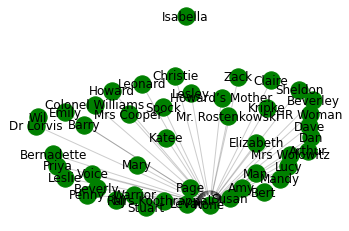

In [136]:
visualize_graph(gos, k=1, alpha=.2)

---

Now, answer the following questions:

**Q1: Who is the most mentioned person?**

**Q2: Sheldon claims that every character in the show is familiar with everyone else through at most one intermediary. Based on the familiarity graph, is this true? If not, at most how many intermediaries are needed?**

**Q3. Who is the character through whom the largest number of these indirect familiarities happen? Calculate an appropriate centrality metric on the familiarity graph to answer this question.**

**Q4. Another claim of Sheldon's is that every recurrent character in the show gossips about all the other recurrent characters. (A) Does the gossip graph possess that property?**

**Q5. Use the gossip graph and the familiarity graph to figure out if for every pair of recurrent characters, one of them has gossiped about the other if and only if they know each other (shared a scene).**

## Quiz

**Quiz A: Given the following adjacency matrix of a graph:**

<img src="imgs/quizA.png">

1. A is a directed graph with average in-degree 4/3
2. A is an undirected graph with average degree 4/3
3. A is a directed graph with average in-degree 1
4. A is an undirected graph with average degree 1

**Quiz B: In a horror scenario, your lost luggage is landing at an airport and being loaded to another random flight and transferred to another airport. This has been going on for months. Given a very large number of iterations, which of the following metrics gives you the probability that your luggage ends up in Geneva airport?**

1. Closeness centrality
2. Page rank
3. Betweenness centrality
4. Katz similarity